# Aligned/Lambdaclass zkVMs benchmarks

## Benchmarks of VM proving times made by Aligned and Lambdaclass

These benchmarks aim to provide a neutral suite for measuring the efficiency of zkVMs. 

You can run this Python notebook yourself to create new plots or analyze the data.

Raw results can be found [here](https://github.com/yetanotherco/zkvm_benchmarks/tree/main/bench_results).


In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [376]:
## Some auxiliary functions

def time_to_seconds(time_str):
    time_str = time_str.strip()
    try:
        if 'm' in time_str:
            parts = time_str.split('m')
            minutes = float(parts[0])
            seconds = 0
            if len(parts) > 1 and parts[1]:
                seconds = float(parts[1].replace('s', ''))
            return minutes * 60 + seconds
        else:
            return float(time_str.replace('s', ''))
    except Exception as e:
        print(f"Error parsing time: {time_str}")
        print(f"Error details: {e}")
        return None
    

def load_data(input_csv_path):
    # Read data from CSV
    # Return DataFrame with columns for Seconds and Minutes
    df = pd.read_csv(input_csv_path)
    df['N'] = df['N'].astype(int)
    
    for idx, row in df.iterrows():
        seconds = time_to_seconds(row['Time'])
    
    df['Seconds'] = df['Time'].apply(time_to_seconds)
    df['Minutes'] = df['Seconds'] / 60
    return df

def print_dataframe(df):
    print("\nData sorted by Prover and N for validation:")
    pd.set_option('display.float_format', '{:.2f}'.format)
    validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
    print(validation_df.to_string())
    
# Format x-axis to show numbers in millions/thousands
def format_func(x, p):
    if x >= 1_000_000:
        millions = x / 1_000_000
        if millions.is_integer():
            return f'{int(millions)}M'
        else:
            return f'{millions:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    return str(int(x))    
    
# Function to plot data
def plot_datapoints_loglog(ax, data, colors):
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        ax.loglog(prover_data['N'], prover_data['Minutes'], 'o-',
                 label=prover, linewidth=2, markersize=8,
                 color=colors[i % len(colors)])    

def plot_data(df, x_label, function_type):
    # Set dark mode style
    plt.style.use('dark_background')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Create single figure with dark background
    plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
    ax = plt.gca()
    ax.set_facecolor('#1a1a1a')
    
    # Plot log-log scale
    plot_datapoints_loglog(ax, df, colors)
    ax.set_xlabel(x_label, color='white')
    ax.set_ylabel('Time (minutes)', color='white')
    ax.set_title(f'{function_type} Performance Comparison (Log-Log Scale)', color='white')
    ax.grid(True, alpha=0.2, color='gray')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
              frameon=True, facecolor='#2d2d2d', edgecolor='white',
              labelcolor='white')
    
    # Set tick colors
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    
    plt.tight_layout()
    
    plt.show()
  
def show_sample_at_n(df, n):    
    # Filter for n
    n_rows = df[df['N'] == n]
    n_display = n_rows[['Prover', 'N', 'Time']].copy()
    n_display['N'] = (n_display['N'] / 1000000)  # Truncates, but no decimals here anyway
    
    display(n_display.rename(columns={'N': 'Bytes (Millions)'}))  

def show_max_sample_time(df):    
    # Dynamically find the maximum N value
    max_n = df['N'].max()
    show_sample_at_n(df, max_n)
    
def calculate_kps(df):
    # Calculate Keccaks per second for highest N value of each prover
    kps_data = []
    for prover in df['Prover'].unique():
        prover_data = df[df['Prover'] == prover]
        max_n_row = prover_data.loc[prover_data['N'].idxmax()]
        
        # Each N represents one Keccak hash
        keccaks_per_second = max_n_row['N'] / max_n_row['Seconds'] / 1024
        
        kps_data.append({
            'Prover': prover,
            'KiB/sec': keccaks_per_second
        })
    
    # Create DataFrame and sort by performance
    kps_df = pd.DataFrame(kps_data)
    kps_df = kps_df.sort_values('KiB/sec', ascending=False)
    
    # Display results as a table
    print("\nKiB hased per second at max sample\n")
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # Optionally, you can use the following line to display it as a table in Jupyter Notebook
    display(kps_df)
    

## GPU Benchmarks on RTX A6000

The data was collected on a server with the following specs:

- GPU: NVIDIA RTX A6000
- RAM: 44GB
- OS: Ubuntu 22 LTS

### Fibonacci Benchmark

In this section we will analyze the performance of Fibonacci for different provers.

The data was loaded from `bench_results/fibo_6_mar_25_A6000.csv`.

#### Load the data

In [377]:
input_csv_path = 'bench_results/fibo_6_mar_25_A6000.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [378]:
print_dataframe(df)


Data sorted by Prover and N for validation:
              Prover        N     Time  Minutes
2              Risc0    10000     1.7s     0.03
5              Risc0   100000     5.6s     0.09
8              Risc0  1000000    48.9s     0.81
11             Risc0  4000000   3m9.8s     3.16
0           SP1-AVX2    10000    13.9s     0.23
3           SP1-AVX2   100000    13.3s     0.22
6           SP1-AVX2  1000000    22.8s     0.38
9           SP1-AVX2  4000000    57.0s     0.95
1   SP1-AVX2-Groth16    10000    53.1s     0.89
4   SP1-AVX2-Groth16   100000    53.7s     0.90
7   SP1-AVX2-Groth16  1000000   1m9.2s     1.15
10  SP1-AVX2-Groth16  4000000  1m36.1s     1.60


#### Data analytics

##### Plot: Log N vs Log Time

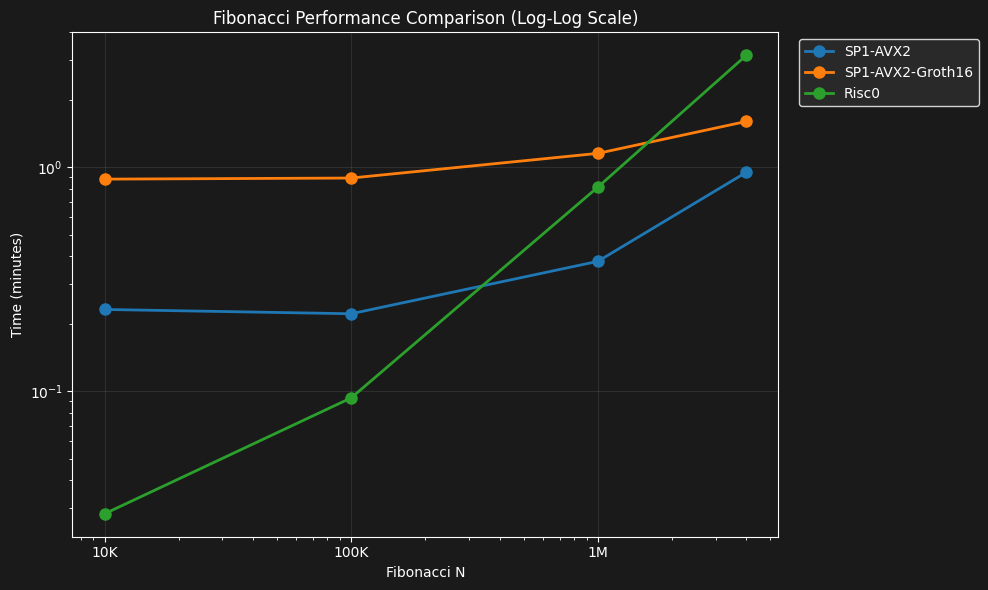

In [379]:
plot_data(df, 'Fibonacci N', 'Fibonacci')

##### Time used at biggest sample taken

In [380]:
show_max_sample_time(df)

,Prover,Bytes (Millions),Time
9,SP1-AVX2,4.00,57.0s
10,SP1-AVX2-Groth16,4.00,1m36.1s
11,Risc0,4.00,3m9.8s


### Keccak Benchmark

In this section we will analyze the performance of Keccak for different provers.

The data was loaded from `bench_results/keccak_6_mar_25_A6000.csv`.

#### Load the data

In [381]:
input_csv_path = 'bench_results/keccak_6_mar_25_A6000.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [382]:
print_dataframe(df)


Data sorted by Prover and N for validation:
              Prover         N     Time  Minutes
2              Risc0       100     7.3s     0.12
5              Risc0      1000     7.5s     0.12
8              Risc0     10000    11.0s     0.18
11             Risc0    100000    43.5s     0.72
14             Risc0   1000000   6m8.0s     6.13
0           SP1-AVX2       100    21.5s     0.36
3           SP1-AVX2      1000    21.8s     0.36
6           SP1-AVX2     10000    22.0s     0.37
9           SP1-AVX2    100000    22.6s     0.38
12          SP1-AVX2   1000000    33.1s     0.55
15          SP1-AVX2  10000000  2m22.0s     2.37
1   SP1-AVX2-Groth16       100    57.2s     0.95
4   SP1-AVX2-Groth16      1000   1m2.6s     1.04
7   SP1-AVX2-Groth16     10000   1m1.6s     1.03
10  SP1-AVX2-Groth16    100000   1m2.6s     1.04
13  SP1-AVX2-Groth16   1000000  1m12.7s     1.21
16  SP1-AVX2-Groth16  10000000   3m2.9s     3.05


#### Data analytics

##### Plot: Log N vs Log Time

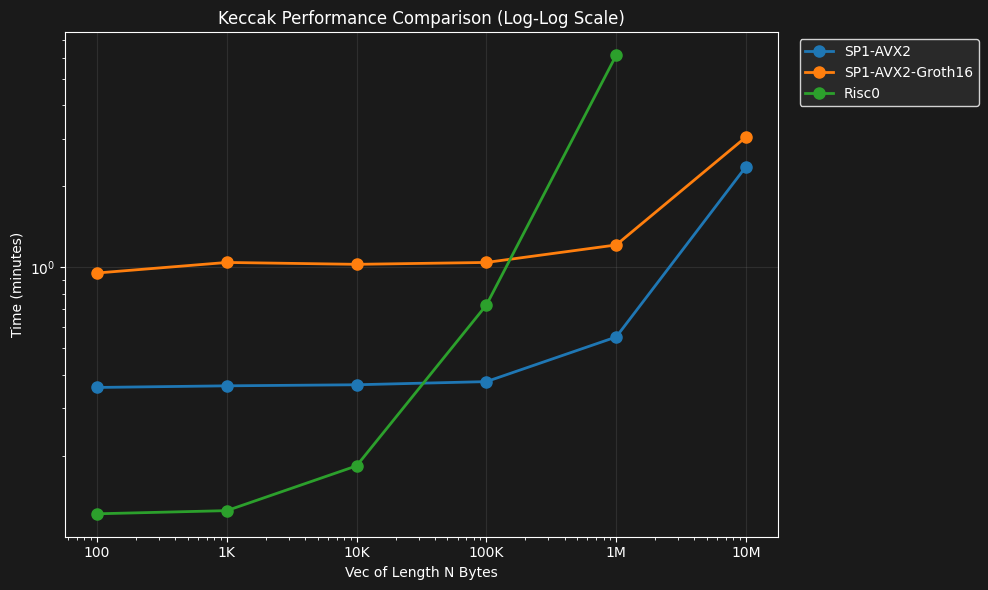

In [383]:
plot_data(df, 'Vec of Length N Bytes', 'Keccak')

##### KiB hased per second at max sample

In [384]:
calculate_kps(df)


KiB hased per second at max sample


,Prover,KiB/sec
0,SP1-AVX2,68.77
1,SP1-AVX2-Groth16,53.39
2,Risc0,2.65


#### Time used at 10M bytes

In [385]:
n = 10000000

show_sample_at_n(df, n)

,Prover,Bytes (Millions),Time
15,SP1-AVX2,10.00,2m22.0s
16,SP1-AVX2-Groth16,10.00,3m2.9s


## CPU Benchmarks on AMD EPYC 8534P 64-Core Processor

The data was collected on a server with the following specs:

- CPU: AMD EPYC 8534P 64-Core Processor
- RAM: 576GB
- OS: Ubuntu 24 LTS

### Fibonacci Benchmark

In this section we will analyze the performance of Fibonacci for different provers.

The data was loaded from `bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv`.

#### Load the data

In [386]:
input_csv_path = 'bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [387]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                Prover        N     Time  Minutes
0          Pico-AVX512    10000    22.9s     0.38
4          Pico-AVX512   100000    35.5s     0.59
8          Pico-AVX512  1000000  1m46.0s     1.77
12         Pico-AVX512  4000000  5m18.6s     5.31
3                Risc0    10000    10.8s     0.18
7                Risc0   100000    50.9s     0.85
11               Risc0  1000000  7m53.1s     7.89
15               Risc0  4000000  31m2.0s    31.03
1           SP1-AVX512    10000    16.0s     0.27
5           SP1-AVX512   100000    34.0s     0.57
9           SP1-AVX512  1000000  1m42.8s     1.71
13          SP1-AVX512  4000000  5m21.2s     5.35
2   SP1-AVX512-Groth16    10000  1m18.5s     1.31
6   SP1-AVX512-Groth16   100000  1m36.4s     1.61
10  SP1-AVX512-Groth16  1000000  2m45.8s     2.76
14  SP1-AVX512-Groth16  4000000  6m29.4s     6.49


#### Data analytics

##### Plot: Log N vs Log Time

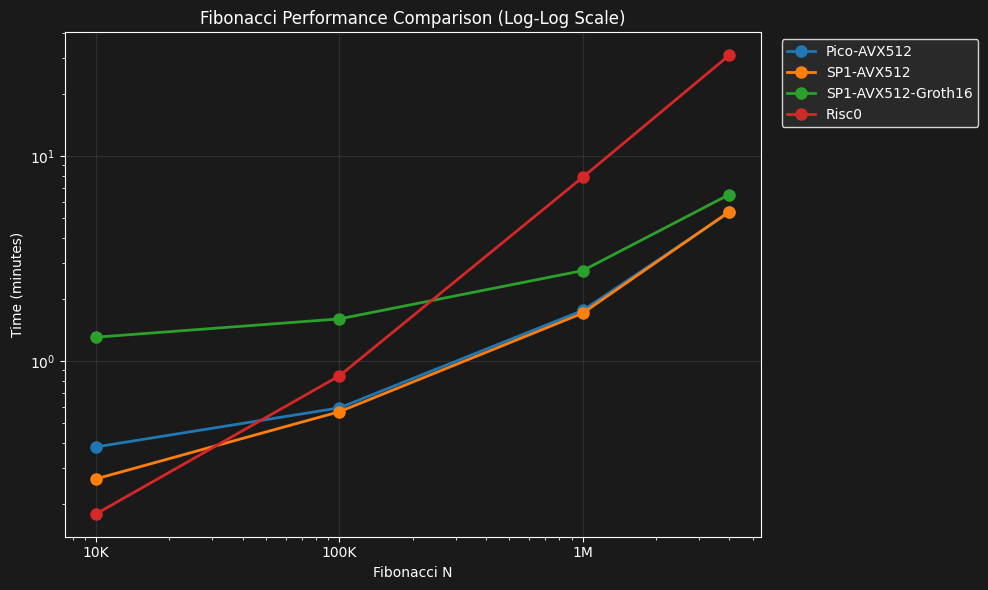

In [388]:
plot_data(df, 'Fibonacci N', 'Fibonacci')

##### Time used at biggest sample taken

In [389]:
show_max_sample_time(df)

,Prover,Bytes (Millions),Time
12,Pico-AVX512,4.00,5m18.6s
13,SP1-AVX512,4.00,5m21.2s
14,SP1-AVX512-Groth16,4.00,6m29.4s
15,Risc0,4.00,31m2.0s


### Keccak Benchmark

In this section we will analyze the performance of Keccak for different provers.

The data was loaded from `bench_results/keccak_5_mar_25_epyc8534p_64c_576gb.csv`.

#### Load the data

In [390]:
input_csv_path = 'bench_results/keccak_5_mar_25_epyc8534p_64c_576gb.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [391]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                Prover         N      Time  Minutes
0          Pico-AVX512       100     28.8s     0.48
3          Pico-AVX512      1000     28.8s     0.48
6          Pico-AVX512     10000     29.8s     0.50
9          Pico-AVX512    100000     39.4s     0.66
12         Pico-AVX512   1000000   1m46.8s     1.78
15         Pico-AVX512  10000000  12m27.4s    12.46
18               Risc0       100     34.4s     0.57
19               Risc0      1000     37.1s     0.62
20               Risc0     10000    1m8.9s     1.15
21               Risc0    100000   6m19.7s     6.33
1           SP1-AVX512       100     53.5s     0.89
4           SP1-AVX512      1000     53.5s     0.89
7           SP1-AVX512     10000     53.3s     0.89
10          SP1-AVX512    100000    1m2.8s     1.05
13          SP1-AVX512   1000000   2m22.6s     2.38
16          SP1-AVX512  10000000  19m51.6s    19.86
2   SP1-AVX512-Groth16       100   1m56.0s     1.93
5   SP1-AVX512-Grot

#### Data analytics

##### Plot: Log N vs Log Time

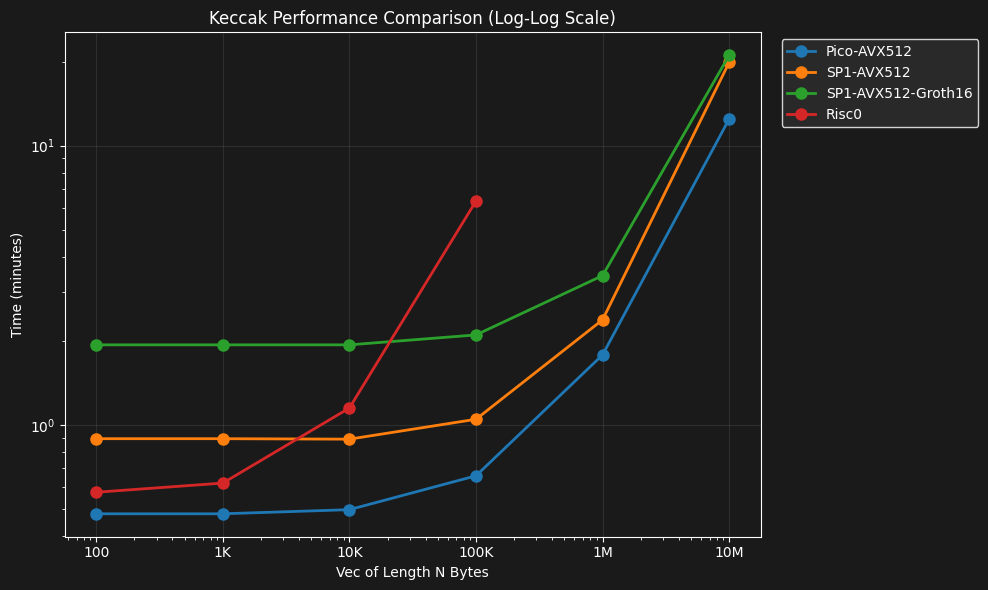

In [392]:
plot_data(df, 'Vec of Length N Bytes', 'Keccak')

##### KiB hased per second at max sample

In [393]:
calculate_kps(df)


KiB hased per second at max sample


,Prover,KiB/sec
0,Pico-AVX512,13.07
1,SP1-AVX512,8.20
2,SP1-AVX512-Groth16,7.73
3,Risc0,0.26


#### Time used at 10K bytes and 10M bytes

In [394]:
n1 = 10000
n2 = 10000000

show_sample_at_n(df, n1)
show_sample_at_n(df, n2)

,Prover,Bytes (Millions),Time
6,Pico-AVX512,0.01,29.8s
7,SP1-AVX512,0.01,53.3s
8,SP1-AVX512-Groth16,0.01,1m56.0s
20,Risc0,0.01,1m8.9s


,Prover,Bytes (Millions),Time
15,Pico-AVX512,10.00,12m27.4s
16,SP1-AVX512,10.00,19m51.6s
17,SP1-AVX512-Groth16,10.00,21m3.5s
